# Variational inference using the finite approximation

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from copy import deepcopy

from valez_finite_VI_lib import *


# Draw data

In [2]:
np.random.seed(12321) # this is a seed where VI works well

Num_samples = 500 # sample size
D = 2 # dimension
# so X will be a N\times D matrix

K_inf = 3 # take to be large for a good approximation to the IBP


alpha = 10 # IBP parameter
Pi = np.ones(K_inf) * .8
Z = np.zeros([Num_samples,K_inf])

# Parameters to draw A from MVN
mu = np.zeros(D)
sigma_A = 100

sigma_eps = .1 # variance of noise

# Draw Z from truncated stick breaking process
for k in range(K_inf):
    # Pi[k] = np.random.beta(alpha/K_inf,1)
    for n in range(Num_samples):
        Z[n,k] = np.random.binomial(1,Pi[k])

        
print('true Z (first 10 rows): \n', Z[0:10,:])

# Draw A from multivariate normal
A = np.random.multivariate_normal(mu, sigma_A*np.identity(D), K_inf)
# A = np.array([[10,10], [-10,10]])
print(A)

# draw noise
epsilon = np.random.multivariate_normal(np.zeros(D), sigma_eps*np.identity(D), Num_samples)

# the observed data
X = np.dot(Z,A) + epsilon


true Z (first 10 rows): 
 [[ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  0.]
 [ 1.  1.  1.]
 [ 1.  0.  1.]
 [ 1.  1.  1.]
 [ 1.  1.  1.]
 [ 1.  0.  0.]]
[[-8.51475909 -6.21216389]
 [-4.87413607  7.73290799]
 [-0.6385297  -4.80839596]]


# set initializations

In [3]:
K_approx = deepcopy(K_inf) # variational truncation

tau = np.random.uniform(0,1,[K_approx,2]) # tau1, tau2 -- beta parameters for v
#tau = np.ones([K_approx,2])*1000
#tau[:,1] = (tau[:,0] - Pi*tau[:,0])/Pi

#nu = np.ones([Num_samples, K_approx]) *0.0
nu =  np.random.uniform(0,1,[Num_samples,K_approx]) # Bernoulli parameter for z_nk
#nu = deepcopy(Z)

phi_mu = np.random.normal(0,1,[D,K_approx]) # kth mean (D dim vector) in kth column
#phi_mu = deepcopy(A).T
phi_var = np.ones(K_approx)

nu_init = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

iterations = 1000
elbo = np.zeros(iterations)
elbo_Term1 = np.zeros(iterations)
elbo_Term2 = np.zeros(iterations)
elbo_Term3 = np.zeros(iterations)
elbo_Term4 = np.zeros(iterations)
elbo_Term5 = np.zeros(iterations)
elbo_Term6 = np.zeros(iterations)
elbo_Term7 = np.zeros(iterations)


Data_shape = {'D':D, 'N': Num_samples , 'K':K_approx}
sigmas = {'eps': sigma_eps, 'A': sigma_A}


In [4]:
def add_noise_to_phi(phi_mu, noise_scale):
    phi_mu = phi_mu + np.random.normal(0, noise_scale, phi_mu.shape)

# run CAVI

In [ ]:
#add_noise_to_phi(phi_mu, 1.0)
sigma_eps_anneal = np.linspace(100, sigma_eps, 10)

for j in range(len(sigma_eps_anneal)): 
    sigmas['eps'] = sigma_eps_anneal[j]
    print('anneal iteration: ', j)
    print(sigmas['eps'])
    
    for i in range(iterations):
        iter_ran = i + 1
        
        cavi_updates(tau, nu, phi_mu, phi_var, X, alpha, sigmas)
        
        '''        
        nu_updates(tau, nu, phi_mu, phi_var, X, sigmas,n,k)

        phi_updates(nu, phi_mu, phi_var, X, sigmas,k)

        tau_updates(tau, nu, alpha)    
        '''


        # round_nu = np.round(nu*(nu>=0.9) + nu*(nu<=0.1)) + nu*(nu>=0.1)*(nu<=0.9)

        [elbo[i],elbo_Term1[i],elbo_Term2[i],elbo_Term3[i],elbo_Term4[i],elbo_Term5[i],elbo_Term6[i],elbo_Term7[i]] \
        = compute_elbo(tau, nu, phi_mu, phi_var, X, sigmas, Data_shape, alpha)

        if i%10 ==0:
            print('iteration: ', i, ' l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]))
            print('elbo: ', elbo[i])
        #print(round_nu[0:10,:])
        #print(nu[0:10,:])
        #print('l1 error: ', np.sum(abs(Z-nu))/np.size(Z[:]) )

        if np.isnan(elbo[i]):
            print('NAN ELBO.')
            break

        if (i>0) & (elbo[i] < elbo[i-1]): 
            print('elbo decreased!  Difference: ', elbo[i] - elbo[i-1])
            break

        if np.abs(elbo[i]-elbo[i-1]) <= 10**(-8):
            print('ELBO converged')
            break
    

anneal iteration:  0
100.0
iteration:  0  l1 error:  0.683945912088
elbo:  -3513.67862921
iteration:  10  l1 error:  0.560874982998
elbo:  -3342.3310616
iteration:  20  l1 error:  0.548158262736
elbo:  -3340.27000392
iteration:  30  l1 error:  0.536089593117
elbo:  -3339.12567562
iteration:  40  l1 error:  0.524520720505
elbo:  -3338.30248044
iteration:  50  l1 error:  0.513448630445
elbo:  -3337.66937127
iteration:  60  l1 error:  0.502860467134
elbo:  -3337.16178428
iteration:  70  l1 error:  0.492739666651
elbo:  -3336.74314174
iteration:  80  l1 error:  0.483068320908
elbo:  -3336.39071214
iteration:  90  l1 error:  0.473828189668
elbo:  -3336.08940234
iteration:  100  l1 error:  0.465001182584
elbo:  -3335.82867914
iteration:  110  l1 error:  0.456569603735
elbo:  -3335.60090006
iteration:  120  l1 error:  0.448516278822
elbo:  -3335.40034395
iteration:  130  l1 error:  0.44082462006
elbo:  -3335.22261667
iteration:  140  l1 error:  0.433478656095
elbo:  -3335.06427007
iteration: 

In [6]:
print(np.shape(X)[0])
print(np.shape(nu)[1])
assert np.shape(X)[0] == np.shape(nu)[1]

500
3


AssertionError: 

('Z \n', array([[ 0.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  0.],
       [ 0.,  1.,  1.],
       [ 1.,  0.,  1.],
       [ 1.,  1.,  1.],
       [ 1.,  1.,  0.]]))
('round_nu \n', array([[ 0.,  1.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  1.,  1.],
       [ 1.,  0.,  1.],
       [ 0.,  0.,  1.],
       [ 0.,  0.,  1.]]))
[ 0.6374  0.6376  0.1538]
[0 1 1]
[[-12.78122302   3.71538761]
 [  8.60462271   9.677958  ]
 [ -4.74617662   6.36868241]]
[[ -8.58505626  -9.75913434]
 [ 12.73112828  -3.6597321 ]
 [ -7.94748982  18.46061194]]


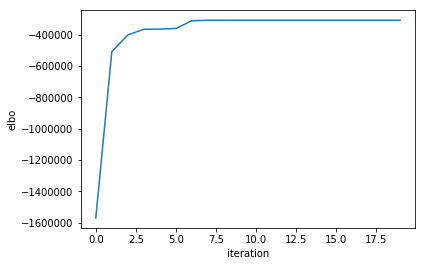

In [107]:
Pi_computed = tau[:,0]/(tau[:,0] + tau[:,1])
print('Z \n', Z[0:10,:])
print('round_nu \n', round_nu[0:10,:])

# Print the minimizing permutation.
accuracy_mat = [[ np.sum(np.abs(Z[:, i] - nu[:, j]))/Num_samples for i in range(K_inf) ]
                  for j in range(K_inf) ]
print np.min(accuracy_mat, 1)
print np.argmin(accuracy_mat, 1)

print A
print phi_mu.transpose()

plt.clf()
plt.plot(elbo[:iter_ran])
plt.xlabel('iteration')
plt.ylabel('elbo')
plt.show()

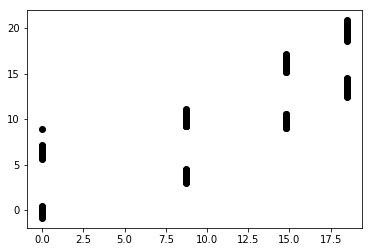

In [112]:
pred_x = np.dot(nu, phi_mu.transpose())
col = 1
plt.clf()
plt.plot(pred_x[:, col], X[:, col], 'ko')
plt.show()

In [109]:
# let us permute the columms of nu and then compare: 
nu_perm = nu[:, (1,2,0)]
round_nu_perm = np.round(nu_perm*(nu_perm>=0.9) + nu_perm*(nu_perm<=0.1)) + nu_perm*(nu_perm>=0.1)*(nu_perm<=0.9)

print(np.sum(np.abs(Z[:,0] - nu_perm[:,0]))/Num_samples)
print(np.sum(np.abs(Z[:,1] - nu_perm[:,1]))/Num_samples)
print(np.sum(np.abs(Z[:,2] - nu_perm[:,2]))/Num_samples)

# so two of the rows are really close ...

0.9566
0.1538
0.706
